## Step 2 - Environmental sound classification with semi-supervised learning
This is the complimentary notebook for the handed in paper. This notebook shows the implementation of the different architecture and the obtained results. 

### Organization of notebook
The notebook is organized into a data and pre-processing section, a model section, a training section and finally a results/visualization section.

First, we import all of the used libraries and set a random seed for reproducability. 

In [1]:
import os
from types import SimpleNamespace

import numpy as np
import keras
import keras.backend as K
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import Input, Dense, Flatten, Reshape,\
    Activation, Dropout, Conv2D, Conv2DTranspose,\
    MaxPooling2D, BatchNormalization, UpSampling2D, Lambda
from keras.models import Model, Sequential
import pescador
import matplotlib
from sklearn.metrics import confusion_matrix
import pandas as pd

from helpers import init_config, conv2d, deconv2d
from plot import plot_images, plot_prediction, plot_conv_weights
from constants import OUTPUT_DIR, MODEL_DIR, PLOT_DIR

# Reproducability
np.random.seed(1337)

Using Theano backend.


### Data and pre-processing
All of the data-loading and pre-processing is implemented in the DataHandler.py file. The raw sound files are loaded and pre-processed into a Log-scaled mel-spectrogram of size $\mathbf{x}_n \in \mathbb{R}^{28 \times 36}$. Either read the data section in the paper or inspect the DataHandler class for more details. The DataHandler class is used as a stream of batches. It takes parameters such as window size, hop-length, and bands.

#### Datasets
For this notebook, we focus on the ESC-US (250.000 unlabeled environmental sounds) and the ESC-50 (2000 labeled environmental sounds. Hence, we have two data streamers, one for each dataset. To run the code, you will need to download the datasets from links (see README.md) and place them into a `./datasets/` folder.   


In [2]:
from DataHandler import DataHandler

#### ESC-US ####
# Unlabeled datahandler
total = 50000
val_size = total // 5
data_handler = DataHandler(bands=28, test_size=16, 
                           val_size=val_size,
                           dataset="ESC-US", hop_length=6*1024, window=12*1024,
                           )

#### ESC-50 ####
# labeled datahandler
l_total = 2000
l_test_size = l_total // 5
l_val_size = (l_total - l_test_size) // 5
labeled_data_handler = DataHandler(bands=28, val_size=l_val_size, test_size=l_test_size,
                                   dataset="ESC-50", hop_length=6*1024, window=12*1024,
                           )


Training dataset size: 39984
Validation dataset size: 10000
Testing dataset size: 16
Training dataset size: 1280
Validation dataset size: 320
Testing dataset size: 400


### Models 
In this notebook, we show the two convolution autoencoders. The difference lies in the invertion of the max-pooling layer. We also include the implementation of extending the pre-trained autoencoders to classifiers as in the semi-supervised approach, and the fully supervised model. 


#### Custom layers
Since neither tensorflow or keras supported the unpooling layer using the stacked-what-where approach, we had to implement this ourselves. The DePool2D class takes the size of the input, size of the max-pool operation we are inverting, and the layer it should be connected to. This is seen below.  

NOTE: The costum dePool2D is only supported by using theano backend to keras. 

In [3]:
from keras.layers import Lambda, multiply
from keras.layers.convolutional import UpSampling2D

def ZeroPad2D(**kwargs):
    def call(inputs, data_format=None):
        from keras import backend as K
        
        y, goal_y = inputs
        shape = K.int_shape(y)
        goal_shape = K.int_shape(goal_y)
        a, b = goal_shape[-2] - shape[-2], goal_shape[-1] - shape[-1]
        y_pad = K.spatial_2d_padding(y, padding=((0, a), (0, b)), data_format=data_format)
        return y_pad

    return Lambda(call, output_shape=lambda x: x[1], arguments=kwargs)

def Where():
    def getwhere(inputs):
        """
        Calculate the 'where' mask that contains switches indicating which
        index contained the max value when MaxPool2D was applied.  Using the
        gradient of the sum is a nice trick to keep everything high level.
        """
        from keras import backend as K
        y_prepool, y_postpool = inputs
        return K.gradients(K.sum(y_postpool), y_prepool)
    
    return Lambda(getwhere, output_shape=lambda x: x[0])

def DePool2D(*args, data_format=None, **kwargs):
    """
    Uses a switch variable as described in https://arxiv.org/pdf/1311.2901.pdf
    Can only invert maxpooling where `size = stride`.
    """

    def call(inputs):
        y_prepool, y_postpool, x = inputs
        where = Where()([y_prepool, y_postpool])
        y = UpSampling2D(*args, data_format=data_format, **kwargs)(x)
        y = ZeroPad2D(data_format=data_format)([y, where])
        return multiply([y, where])
    
    return call

def Upsampling2DPadded(*args, data_format=None, **kwargs):
    def call(inputs):
        prepool, postpool, x = inputs
        y = UpSampling2D(*args, data_format=data_format, **kwargs)(x)
        y = ZeroPad2D(data_format=data_format)([y, prepool])
        return y

    return call


#### Convolutional Autoencoder
The convolutional autoencoder is implemented below. It takes a configuration dictionary, where all of the hyper-parameters are declared. If the configuration settings conf.use_depool value is set to true, a custom unpooling layer is used. If not, the Upsampling2DPadded layer is used, which is also implemented under Custom layers section. 

In [4]:
# Convolutional autoencoder
def deeper_nodense(conf):
    num_filters = conf.num_filters or 64
    # Encoder

    unpool = DePool2D if conf.use_depool else Upsampling2DPadded

    kwargs = { 'data_format': "channels_first" }
    pool_size = 2

    # (64)5c-2p-(64)3c-2p-(64)3c-2p-10fc
    x = Input(shape=conf.original_img_size)

    conv1 = conv2d(num_filters, 5, name="conv1", use_batch_normalization=conf.use_batch_normalization, **kwargs)(x)
    maxp1 = MaxPooling2D(pool_size=(pool_size, pool_size), **kwargs)(conv1)
    conv2 = conv2d(num_filters, 3, name="conv2", use_batch_normalization=conf.use_batch_normalization, **kwargs)(maxp1)
    
    if conf.num_layers == 3:
        maxp2 = MaxPooling2D(pool_size=(pool_size, pool_size), **kwargs)(conv2)
        conv3 = conv2d(num_filters, 3, name="conv3", use_batch_normalization=conf.use_batch_normalization, **kwargs)(maxp2)
        maxp3 = MaxPooling2D(name=conf.encoded_name, pool_size=(pool_size, pool_size), **kwargs)(conv3)
        z = maxp3
    else:
        maxp2 = MaxPooling2D(name=conf.encoded_name, pool_size=(pool_size, pool_size), **kwargs)(conv2)
        z = maxp2
        
    y = z
    if conf.num_layers == 3:
        y = unpool(size=(pool_size, pool_size), **kwargs)([conv3, maxp3, y])
        y = deconv2d(num_filters, 3, **kwargs)(y)
    
    y = unpool(size=(pool_size, pool_size), **kwargs)([conv2, maxp2, y])
    y = deconv2d(num_filters, 3, use_batch_normalization=conf.use_batch_normalization, **kwargs)(y)
    y = unpool(size=(pool_size, pool_size), **kwargs)([conv1, maxp1, y])
    y = deconv2d(1, 5, use_batch_normalization=conf.use_batch_normalization, activation=None, **kwargs)(y)

    # AE
    ae = Model(inputs=x, outputs=y)
    optimizer = Adam(lr=conf.learning_rate, decay=conf.decay)
    ae.compile(optimizer=optimizer, loss='mse')

    encoder = Model(x, z)

    return ae, encoder


#### Pre-trained weights classifier and supervised classifier
This model takes an autoencoder as input, extracts the encoder part, and then extends it with two fully connected layers. The first is of 128 hidden units and the next one is the classification layer with 50 output units and a softmax activation function. The autoencoder is already trained, if we are building a model with pre-trained weights.

This function is also used for building the fully supervised classifier with no pre-trained weights. In this case, an autoencoder is build and passed (but not pre-trained) and we are therefore sure to have two classifiers with same architecture, but one with pre-training of weights and one without. 


In [5]:
def build_pretrained_classifier(ae, class_conf):
    encoded = ae.get_layer(class_conf.encoded_name).output
    hidden_units = class_conf.hidden_units or 200

    if len(class_conf.latent_dim) > 1:
        y = Flatten(input_shape=class_conf.latent_dim)(encoded)
        y = Dense(hidden_units)(y)
    else:        
        y = Dense(hidden_units, input_shape=class_conf.latent_dim)(encoded)
    if class_conf.dropout > 0:
        y = Dropout(class_conf.dropout)(y)
    y = Dense(class_conf.num_classes, activation='softmax')(y)
    
    classifier = Model(ae.inputs, y)
    classifier.compile(optimizer=keras.optimizers.Adam(),
                       loss=keras.losses.categorical_crossentropy,
                       metrics=['accuracy'])
    return classifier

We are also need of a method used to the load weights from a pre-trained autoencoder. It is very simple as below: 

In [6]:
def load_weights(model, uuid):
    model.load_weights(os.path.join(MODEL_DIR, uuid + '.h5'))

### Training
We are now ready to perform the training of our models. 

#### Autoencoder 
First, we include the training process of our convolutional autoencoder. We already defined our batch streamers from our own implemented DataLoader.py. The DataLoader class also takes care of splits, number of updates per epoch and everything else relevant to data.  

We use early stopping with a patience of 5 and only save the best performing model. The number of epochs is set in the configuration file (conf) when the training method is called. We return the training-history if we need to plot the evolving graphs from the model. 

In [7]:
def train_ae(ae, conf, data_handler, save=True):
    batches = data_handler.get_train_batch_streamer(conf.batch_size)
    batches_validation = data_handler.get_validation_batch_streamer(
        conf.batch_size)

    checkpoints = [
            keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
        ]
    
    if save:
        save_path = os.path.join(MODEL_DIR, conf.uuid + ".h5")
        checkpoints.append(ModelCheckpoint(save_path, monitor='val_loss',
                                           save_weights_only=True,
                                           verbose=1, mode='auto'))
        checkpoints.append(CSVLogger(os.path.join(OUTPUT_DIR, conf.uuid + ".log")))

    history = ae.fit_generator(
        pescador.tuples(batches, 'X', 'X'),
        steps_per_epoch=data_handler.number_of_train_batches,
        epochs=conf.epochs,
        verbose=1,
        validation_data=pescador.tuples(batches_validation, 'X', 'X'),
        validation_steps=data_handler.number_of_val_batches,
        callbacks=checkpoints)

    return history

The training function is called from the following autoencoder function. If given the parameter train=False, then we return an untrained autoencoder, which is used for the supervised classifier. If not, we call the training function giving us an autoencoder with pre-trained weights. 

The configuration dictionary is declared here. In order to experiment with different hyper-parameters, you will need to change the values here or specify the extra_conf dictionary parameter. 

In [8]:
def autoencoder(load=True, train=False, extra_conf={}):
    img_shape = data_handler.get_X_shape()
    
    conf = SimpleNamespace(**{
        'batch_size': 16,
        'epochs': 50,
        'learning_rate': 0.001,
        'decay': 0.0,
        "uuid": "nodense-ae",
        "encoded_name": "encoded",
    }) 
    conf = init_config(img_shape, conf, extra_conf)
    ae, encoder = deeper_nodense(conf)
    
    if load:
        load_weights(ae, conf.uuid)
    if train:
        train_ae(ae, conf, data_handler, save=True)
        plot_prediction(ae, data_handler, save_name=conf.uuid)
    return ae

#### Classifier training
The classifier training function is very similar to the autoencoder classifier. The main difference is that we map the output values to one-hot encodings. Again, a configuration dictionary is provided for all of the hyper-parameters. 

In [9]:
def create_onehot_transformer(num_classes):
    def transform_batches_to_latent_space(xy):
        x, y = xy
        one_hot = keras.utils.to_categorical(y, num_classes=num_classes)
        return (x, one_hot)

    return transform_batches_to_latent_space

def train_classifier(classifier, class_conf, data_handler, save=True):
    batches = data_handler.get_train_batch_streamer(class_conf.batch_size)
    batches_validation = data_handler.get_validation_batch_streamer(
        class_conf.batch_size)
    
    # Map stream generators to one-hot encodings y 
    to_onehot = create_onehot_transformer(class_conf.num_classes)
    batches_train_gen = map(to_onehot, pescador.tuples(batches, 'X', 'y'))
    batches_valid_gen = map(to_onehot, pescador.tuples(batches_validation, 'X', 'y'))

    checkpoints = [
            keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto')
        ]
    
    if save:
        checkpoints.append(ModelCheckpoint(os.path.join(MODEL_DIR, class_conf.uuid + ".h5"), monitor='val_acc',
                                           save_weights_only=True,
                                           verbose=1, mode='auto'))
        checkpoints.append(CSVLogger(os.path.join(OUTPUT_DIR, class_conf.uuid + ".log")))

    classifier.fit_generator(
        batches_train_gen,
        steps_per_epoch=data_handler.number_of_train_batches,
        epochs=class_conf.epochs,
        verbose=1,
        validation_data=batches_valid_gen ,
        validation_steps=data_handler.number_of_val_batches,
        callbacks=checkpoints)

The train_classifier function is called in a classify training function, which specifies also a configuration dictionary and loads weights, if we are using a pre-training model. Again, to experiment with different hyper-parameters, you will need to change them here or in the higher function calls. 

In [10]:
def _classify(ae, load=True, extra_conf={}): 
    encoded_name = "encoded"
    img_shape = data_handler.get_X_shape()
    z_size = K.int_shape(ae.get_layer(encoded_name).output)[1:]
    class_conf = SimpleNamespace(**{
        'batch_size': 16,
        'epochs': 150,
        "encoded_name": encoded_name,
        "uuid": "nodense-classify",
        "latent_dim": z_size, # Depends on z dimensionality in AE.
        "num_classes": 50,
        "learning_rate": 0.001,
        "decay": 0.0,
        "dropout": 0.5,
    }) 
    class_conf = init_config(img_shape, class_conf, extra_conf)
    classifier = build_pretrained_classifier(ae, class_conf)
    if load:
        load_weights(classifier, class_conf.uuid)
    else:
        train_classifier(classifier, class_conf, labeled_data_handler)
    return classifier



#### Connecting it all together
We have now defined the different training functions used for the different architectures. The final function run() first trains a supervised classifier without pre-trained weights. Then it trains an autoencoder, loads the pre-trained weights for the classifier and finally fine-tunes the classifier model using a semi-supervised learning approach. 

Even when trained on a GPU, the training time is far above 24 hours. If a wallclock limit is reached, it is possible to resume training with already trained weights by setting load=true for the semi-supervised model. 

In [11]:
def test_accuracy(classifier):
    tests_batches = labeled_data_handler.get_test_batch_streamer(16)
    to_onehot = create_onehot_transformer(num_classes=50)
    batches_gen = map(to_onehot, pescador.tuples(tests_batches, 'X', 'y'))
    accuracy = classifier.evaluate_generator(batches_gen , steps=labeled_data_handler.number_of_test_batches)
    print(accuracy)

def run(extra_conf, load=False, train=True):
    conf = {
        'use_depool': True,
        'hidden_units': 128,
        'batch_size': 32, 
        'num_filters': 64, 
        'dropout': 0.0,
        'use_batch_normalization': False, 
        'num_layers': 3
    }
    conf.update(extra_conf)
    pooltype = 'unpool' if conf['use_depool'] else 'upsampl'

    if load is False:
        # Supervised classifier
        conf['lambda_uuid'] = lambda uuid: "cnn-{}-{}-bs{}-fs{}-d{}-bn{}-l{}-hu{}".format(
                pooltype, uuid, conf['batch_size'], conf['num_filters'], conf['dropout'],
                conf['use_batch_normalization'], conf['num_layers'], conf['hidden_units'])
        ae = autoencoder(load=load, train=False, extra_conf=conf)
        classifier = _classify(ae, load=load, extra_conf=conf)
        test_accuracy(classifier)

    # Semi-supervised learning 
    conf['lambda_uuid'] = lambda uuid: "{}-{}-bs{}-fs{}-d{}-bn{}-l{}-hu{}".format(
            pooltype, uuid, conf['batch_size'], conf['num_filters'], conf['dropout'], 
            conf['use_batch_normalization'], conf['num_layers'], conf['hidden_units'])
    ae = autoencoder(load=load, train=train, extra_conf=conf)
    classifier = _classify(ae, load=load, extra_conf=conf)
    
    if load is False:
        test_accuracy(classifier)
    
    return ae, classifier


#### Hyper-parameters
To run the different models from the handed-in paper, you can call the run function as following, using one of the setups from the models dictionary. The parameters are propagated down to the other configuration dictionaries and hence used for training and initialization of models. By default, the following will use the hyperparameters used for our best performing model. 

In [12]:
import sys

models = [
    {'batch_size': 16, 'num_filters': 64},
    {'batch_size': 32, 'num_filters': 64}, 
    {'batch_size': 64, 'num_filters': 64},
    {'batch_size': 16, 'num_filters': 64, 'use_depool': False},
]

To run training (which can take several hours) comment out the first line.

In [13]:
%%script false
run(models[1])

### Results and Visualizations

We here consider the best performing model for classification `(64)5c-2p-(64)3c-2p-(64)3c-2p` using a batch size of 32.
Models for which trained weights are saved can be found in `outputs/`.

In [14]:
ae, classifier = run(models[1], load=True, train=False)

#### Reconstructions

The reconstruction on the test dataset are very similar to the ground truth.
Here the top is the ground truth and the bottom shows the reconstruction by the AE.

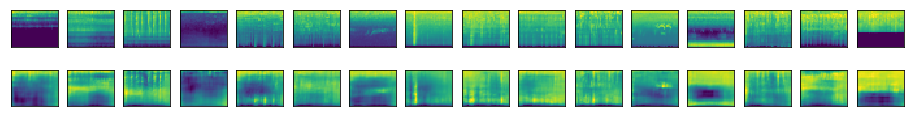

In [15]:
plot_prediction(ae, data_handler)

#### Confusion Matrix

A confusion matrix is constructed to better evaluate the accuracy of the model.
There does not seem to be any obvious pattern in the mis-predictions.

In [16]:
def predict(classifier):
    tests_batches = labeled_data_handler.get_test_batch_streamer(labeled_data_handler.test_size)
    batch = next(tests_batches)
    predictions = classifier.predict_on_batch(batch['X'])
    y = batch['y']
    return predictions.argmax(axis=1), y

def create_confusion_matrix(classifier):
    predictions, expected = predict(classifier)
        
    matrix = confusion_matrix(expected, predictions)
    matrix_df = pd.DataFrame(matrix)
    # plot_confusion_matrix(matrix, classes=labeled_data_handler.esc_50_list)
    return matrix_df

pd.options.display.max_columns = 50
create_confusion_matrix(classifier)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Filters

We can plot the convolutional kernels to get insight into what features it learns.
It is difficult to see clear edge detection as is usual on image recognition tasks.
This is expected considering it is trained on spectograms.
However, the weights does not seem completely random.

W shape :  (64, 5, 5)
W shape :  (4096, 3, 3)
W shape :  (4096, 3, 3)


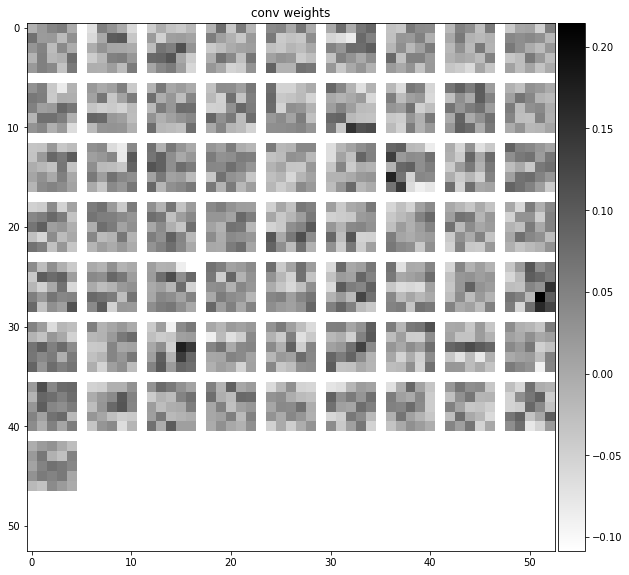

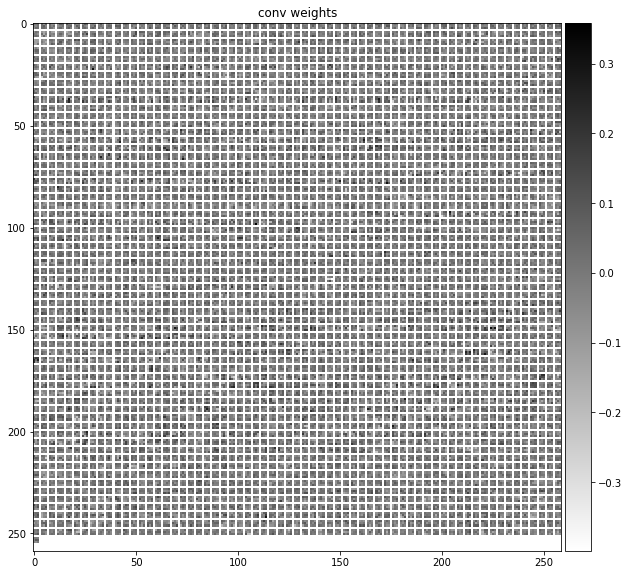

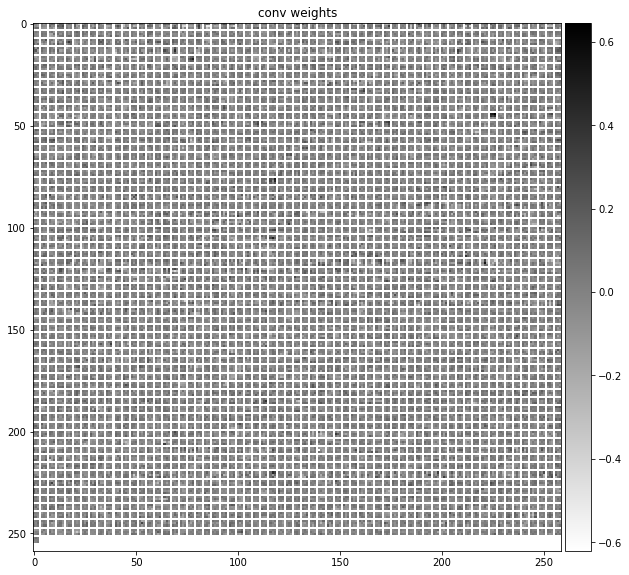

In [17]:
plot_conv_weights(classifier, layer_name="conv1")
plot_conv_weights(classifier, layer_name="conv2")
plot_conv_weights(classifier, layer_name="conv3")

#### Accuracy during Training

Finally training and validation accuracy during training is plotted.
The high training accuracy suggest that the models overfit and that some regulization is needed to improve validation and testing accuracy.

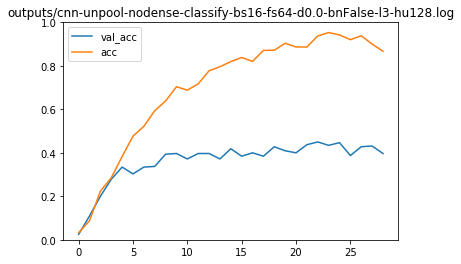

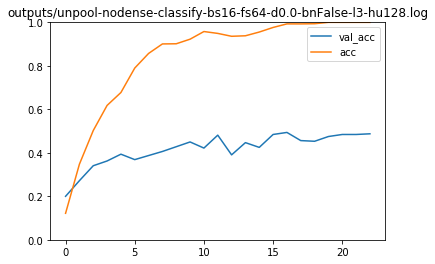

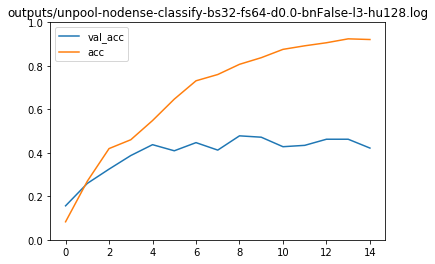

In [18]:
import pandas as pd
import glob

for path in glob.glob(os.path.join("outputs", "*.log")):
    try:
        data = pd.read_csv(path)
        data[['val_acc', 'acc']].plot(title=path, ylim=(0,1))
    except:
        pass